MODEL-CNN(NON-SYNTHETIC)

In [2]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf


from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [5]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")

In [6]:
folds.head(10)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
6,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
7,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
8,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
9,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
df = pd.DataFrame(folds.iloc[:7909])
df.head(10)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
6,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
7,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
8,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
9,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [8]:
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df.head(10)

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
6,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
7,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
8,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
9,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


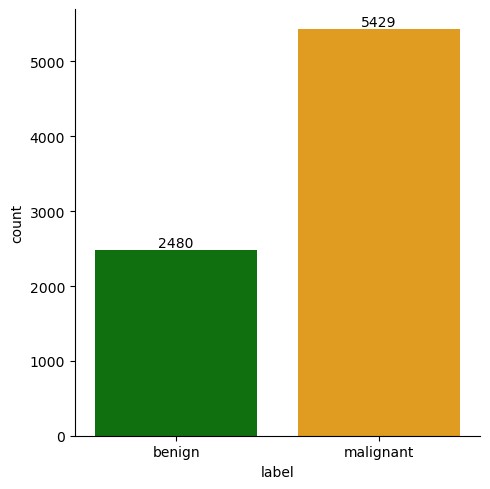

In [9]:
# Striping any leading/trailing whitespace from the below labels
df['label'] = df['label'].str.strip()

# Creating the plot with counts
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)

# This code is to ensure that the bar data labels is served to all the bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# visualization of the plot
plt.show()

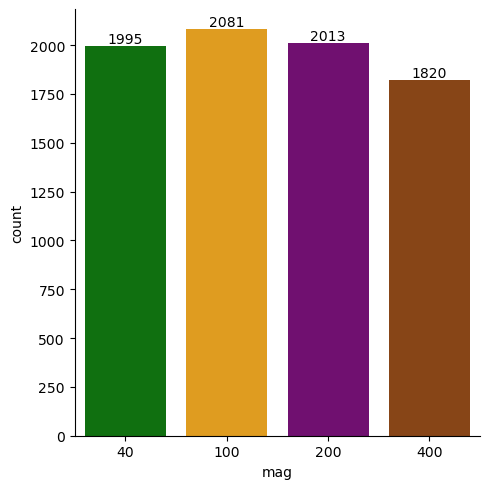

In [10]:
g = sns.catplot(x="mag", data=df, kind="count", hue="mag", palette=['green', 'orange', 'purple', "#9a4204"], legend=False)

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# Show the plot
plt.show()

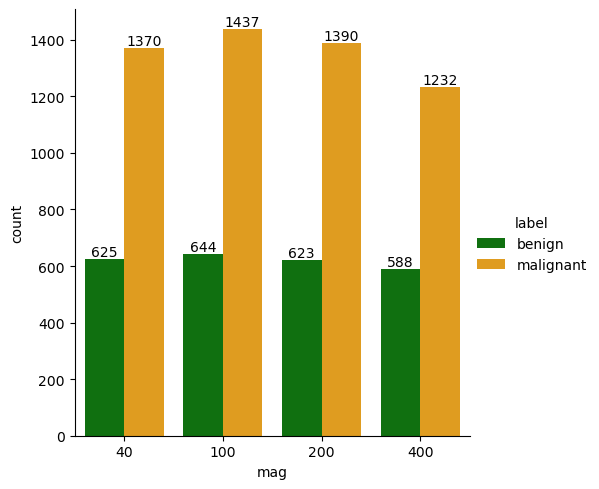

In [11]:
g = sns.catplot(x="mag", data=df, hue="label", kind="count", palette=['green', 'orange'])
for ax in g.axes.flat:
    for c in ax.containers:
        ax.bar_label(c)
plt.show()

Splitting of the data and load images

In [13]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

In [14]:
random_state = 42

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [16]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(( "/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_test, y_test))

In [17]:
def parse_image(path, label):
    """
    Reads image data for given path.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label


def resize_rescale(image, label):
    """
    Resizes given image to desired size.
    """
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255
    return img, label

In [18]:
X_trainset = train_loader.shuffle(len(X_train)).map(parse_image).map(resize_rescale).batch(64)
X_testset = test_loader.shuffle(len(X_test)).map(parse_image).map(resize_rescale).batch(64)

Visualize a dataset sample

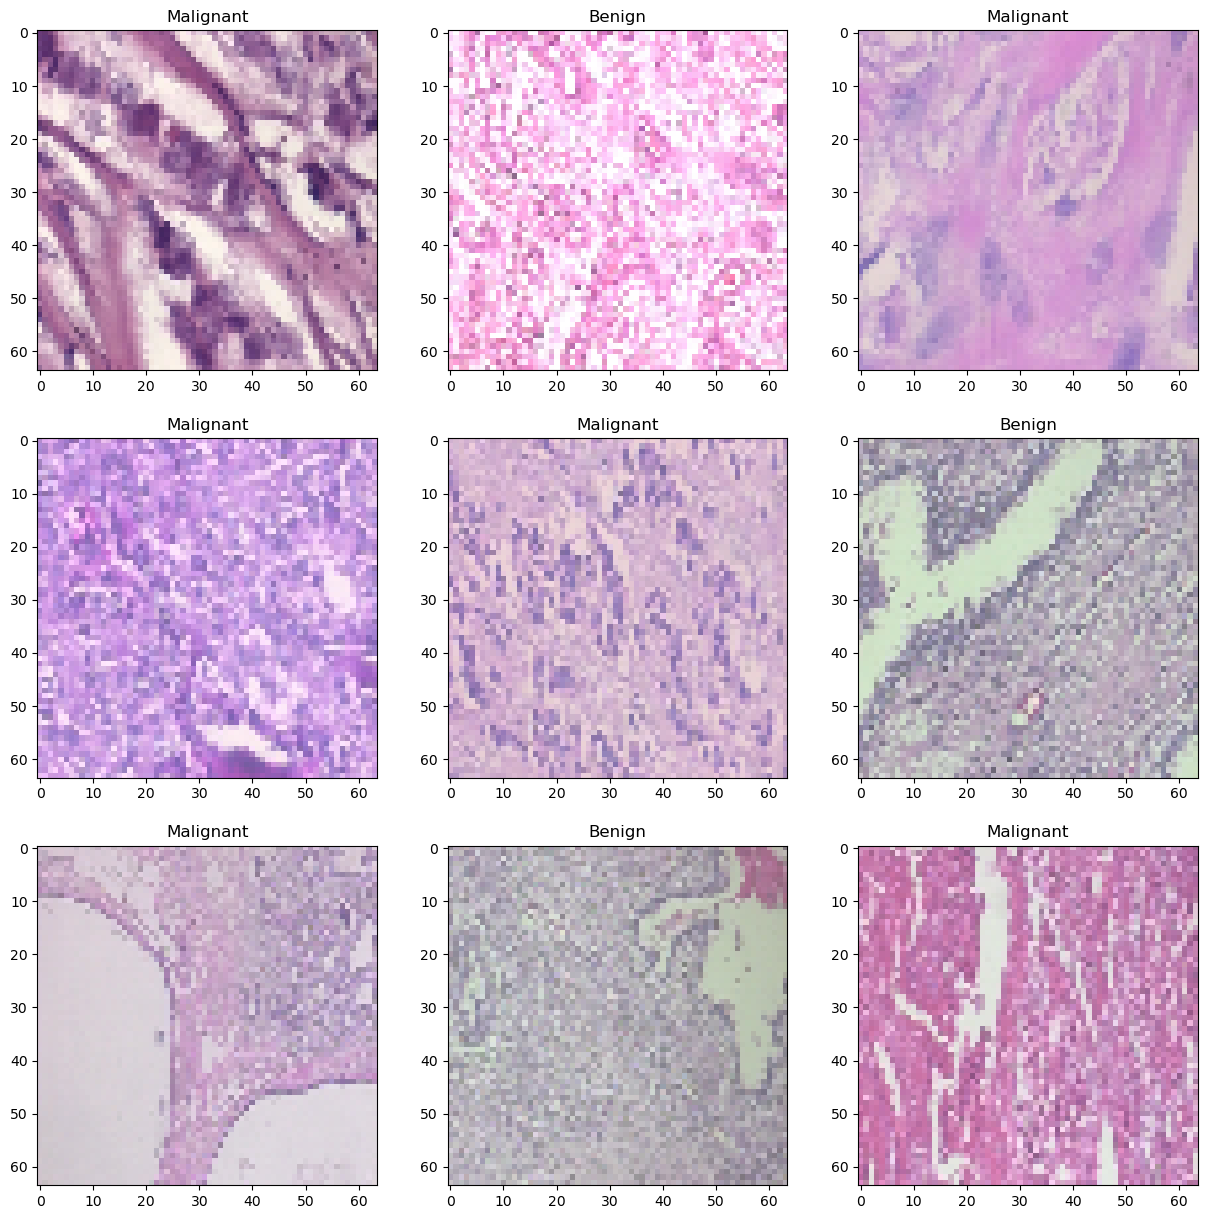

In [20]:
fig = plt.figure(figsize=(15, 15))
for i, img in enumerate(X_trainset):
    if i == 9:
        break
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(img[1][i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[0][i])
plt.show()

Build and evaluate a model
Created model: convolutional neural network + fully-connected layer.

In [22]:
from tensorflow.keras import models, layers, Input

img_shape = (64, 64, 3)

# Here i have created the CNN model
model = models.Sequential()
model.add(Input(shape=img_shape))
model.add(layers.Conv2D(32, 5, padding='same', activation='relu', strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(layers.Conv2D(64, 5, activation='relu', strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(layers.Conv2D(128, 5, activation='relu', strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(2, activation="softmax"))

In [23]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics= ["accuracy"])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    20,480,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,742,978 (79.13 MB)

 Trainable params: 20,742,978 (79.13 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
def plotTrainingHistory(model):
    history = model.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['accuracy'], label='train')
    ax1.plot(history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history['loss'], label='train')
    ax2.plot(history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

In [31]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

In [33]:
history_model = model.fit(X_trainset, epochs=25, verbose=1, validation_data=(X_testset), callbacks=[earlystopping])

Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6641 - loss: 1.8302 - val_accuracy: 0.6448 - val_loss: 0.5703
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.7972 - loss: 0.4711 - val_accuracy: 0.7491 - val_loss: 0.5124
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8208 - loss: 0.4425 - val_accuracy: 0.8306 - val_loss: 0.4330
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8035 - loss: 0.4571 - val_accuracy: 0.8306 - val_loss: 0.4141
Epoch 5/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8267 - loss: 0.4245 - val_accuracy: 0.8413 - val_loss: 0.4050
Epoch 6/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8341 - loss: 0.4229 - val_accuracy: 0.7807 - val_loss: 0.4659
Epoch 7/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8256 - loss: 0.4391 - val_accuracy: 0.8439 - val_loss: 0.3950
Epoch 8/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8298 - loss: 0.4197 - val_accuracy: 0.8281 - v

In [35]:
score_model = model.evaluate(X_testset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - accuracy: 0.8644 - loss: 0.3649


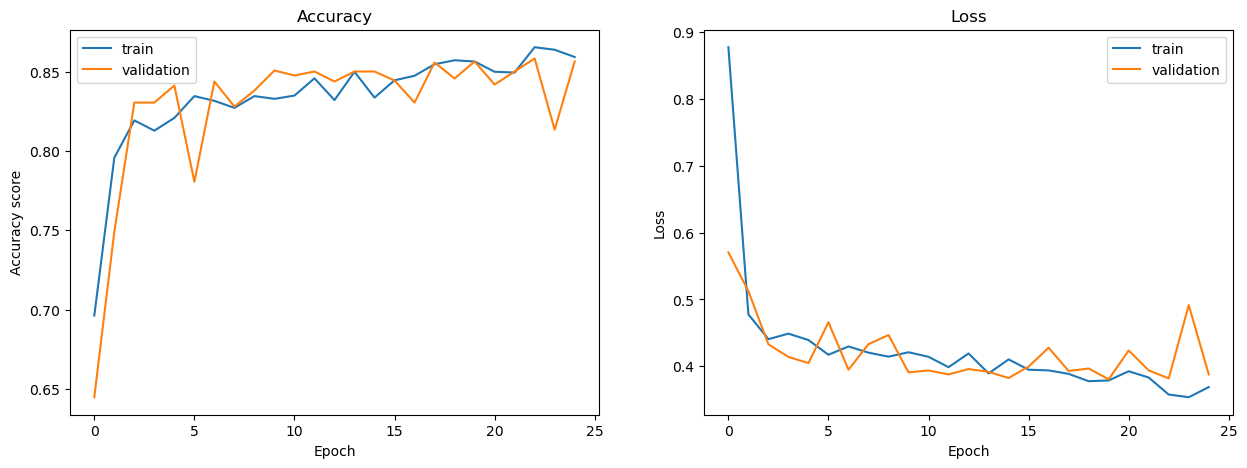

In [37]:
plotTrainingHistory(history_model)

In [39]:
y_test_pred = model.predict(X_testset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step


In [40]:
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)

2024-07-09 20:29:49.933874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
print(classification_report(true_categories, predicted_categories, target_names=["Benign", " Malignant"]))

              precision    recall  f1-score   support

      Benign       0.37      0.35      0.36       510
   Malignant       0.70      0.72      0.71      1072

    accuracy                           0.60      1582
   macro avg       0.54      0.54      0.54      1582
weighted avg       0.59      0.60      0.60      1582



<Axes: >

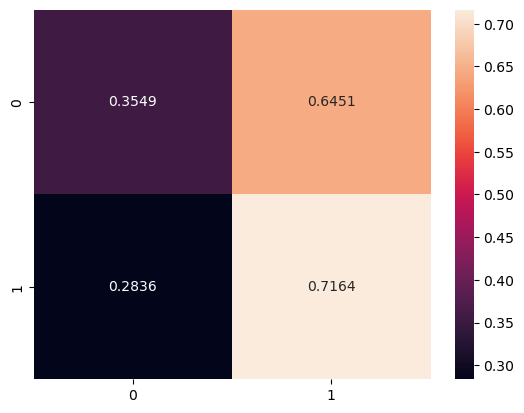

In [42]:
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')

In [43]:
def plotScoresHist(model, X_testset, conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100
         for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("percentage of correctly classified images")
    plt.xlabel('percentage')
    plt.ylabel('class')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

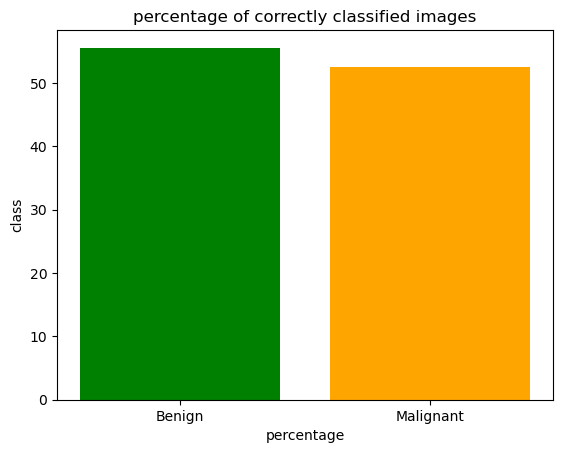

In [45]:
plotScoresHist(model, X_testset, conf_mat)

Balancing the dataset using Data Augmentation

In [53]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [55]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = pd.DataFrame(folds.iloc[:7909])
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df['label'] = df['label'].str.strip()


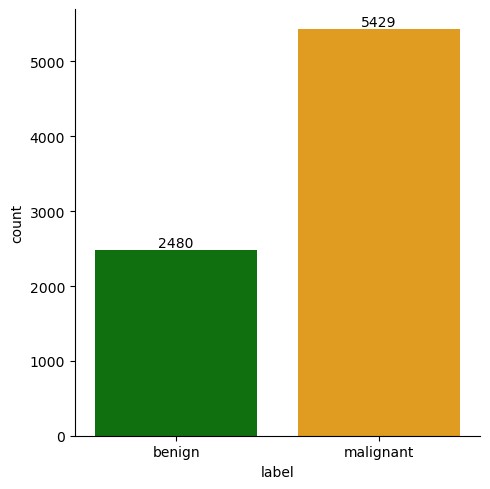

In [57]:
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)
plt.show()

In [59]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [61]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test, y_test))

In [63]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label


In [65]:
def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255.0
    return img, label


In [67]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [69]:
# Apply augmentation to the training dataset
X_trainset = train_loader.map(parse_image).map(augment_image).map(resize_rescale).shuffle(len(X_train)).batch(64)
X_testset = test_loader.map(parse_image).map(resize_rescale).batch(64)

2024-07-09 20:52:03.459876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2812 of 6327
2024-07-09 20:52:15.035976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-09 20:52:15.089349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


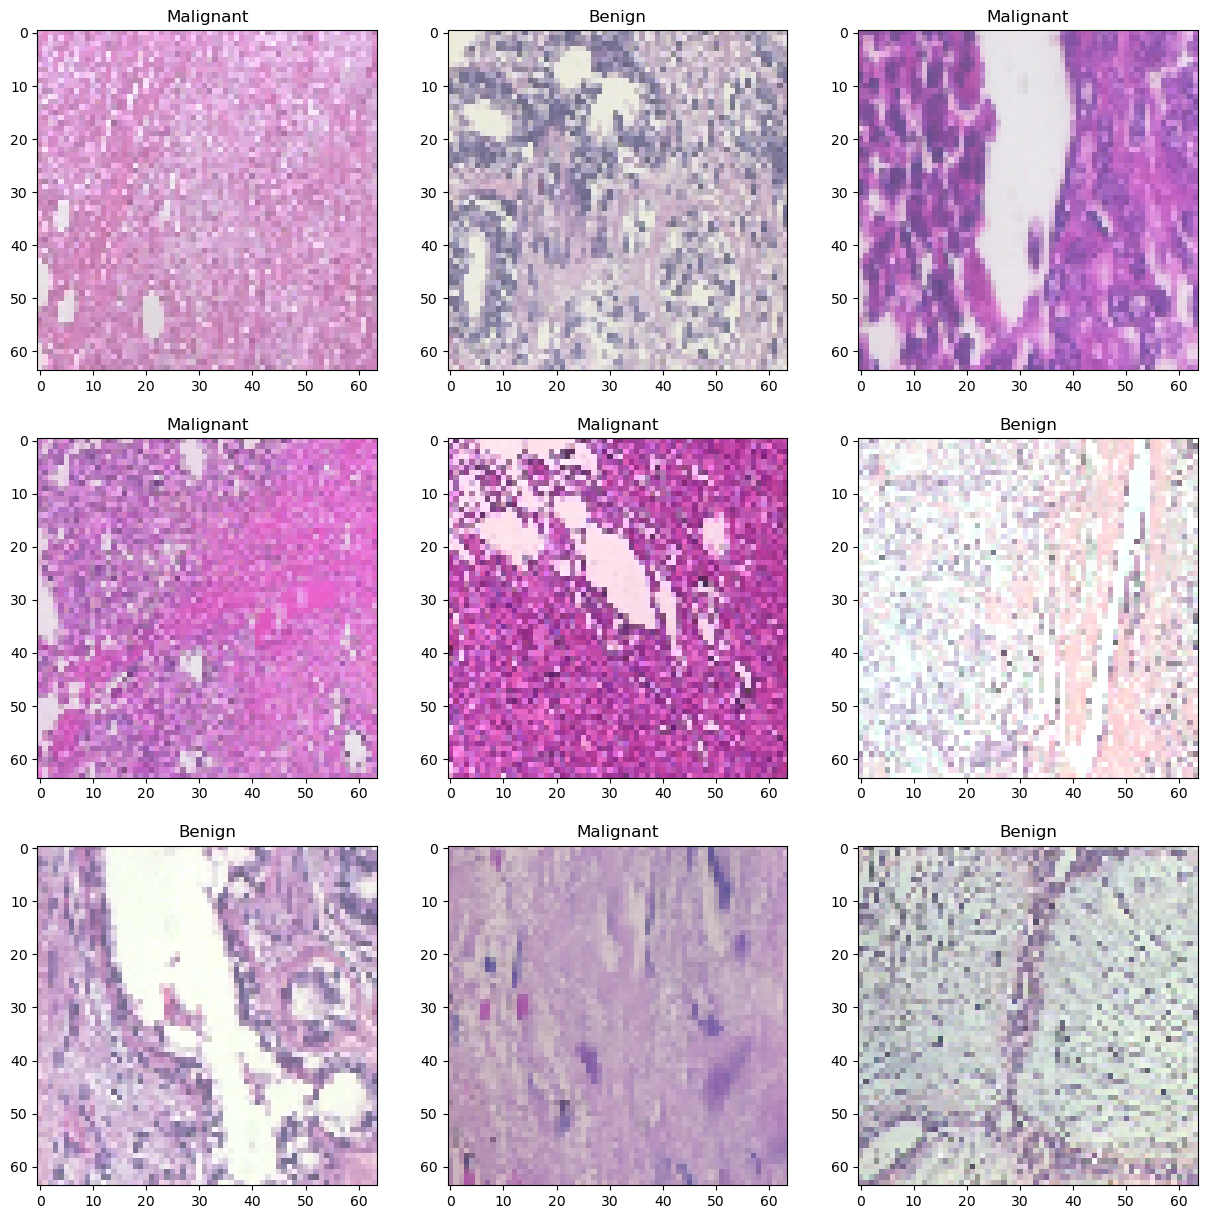

In [71]:
fig = plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(X_trainset.take(9)):
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(label[i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[i])
plt.show()

In [75]:
img_shape = (64, 64, 3)
model = models.Sequential([
    Input(shape=img_shape),
    layers.Conv2D(32, 5, padding='same', activation='relu', strides=(1, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    layers.Conv2D(64, 5, activation='relu', strides=(1, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    layers.Conv2D(128, 5, activation='relu', strides=(1, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │    20,480,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,742,978 (79.13 MB)

 Trainable params: 20,742,978 (79.13 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
def plotTrainingHistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

In [79]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

Epoch 1/25


2024-07-09 20:54:20.459573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2810 of 6327
2024-07-09 20:54:30.460837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5878 of 6327
2024-07-09 20:54:31.936254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5869 - loss: 1.4127 - val_accuracy: 0.6593 - val_loss: 0.6392
Epoch 2/25


2024-07-09 20:56:43.913362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2803 of 6327
2024-07-09 20:56:53.914008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5845 of 6327
2024-07-09 20:56:55.445632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7096 - loss: 0.5837 - val_accuracy: 0.7484 - val_loss: 0.5308
Epoch 3/25


2024-07-09 20:59:02.399558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2875 of 6327
2024-07-09 20:59:13.560413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7634 - loss: 0.5248 - val_accuracy: 0.6245 - val_loss: 0.6474
Epoch 4/25


2024-07-09 21:01:23.090288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2836 of 6327
2024-07-09 21:01:34.628216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.7670 - loss: 0.5156 - val_accuracy: 0.7193 - val_loss: 0.5687
Epoch 5/25


2024-07-09 21:03:51.638644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2681 of 6327
2024-07-09 21:04:04.349792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7954 - loss: 0.5213 - val_accuracy: 0.8287 - val_loss: 0.4223
Epoch 6/25


2024-07-09 21:06:25.427348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2673 of 6327
2024-07-09 21:06:35.425584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5504 of 6327
2024-07-09 21:06:38.247920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8306 - loss: 0.4623 - val_accuracy: 0.8287 - val_loss: 0.5164
Epoch 7/25


2024-07-09 21:09:02.314740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2611 of 6327
2024-07-09 21:09:15.485826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 897s 9s/step - accuracy: 0.7883 - loss: 0.5159 - val_accuracy: 0.8451 - val_loss: 0.4458
Epoch 8/25


2024-07-09 21:23:59.039596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2855 of 6327
2024-07-09 21:24:10.389842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8108 - loss: 0.4745 - val_accuracy: 0.8255 - val_loss: 0.4806
Epoch 9/25


2024-07-09 21:26:14.493432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2879 of 6327
2024-07-09 21:26:25.804186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 2857s 29s/step - accuracy: 0.8045 - loss: 0.4834 - val_accuracy: 0.7415 - val_loss: 0.5666
Epoch 10/25


2024-07-09 22:13:51.158241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 2855 of 6327
2024-07-09 22:14:01.159060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5975 of 6327
2024-07-09 22:14:02.323762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8087 - loss: 0.4893 - val_accuracy: 0.7946 - val_loss: 0.5089
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.8270 - loss: 0.4178


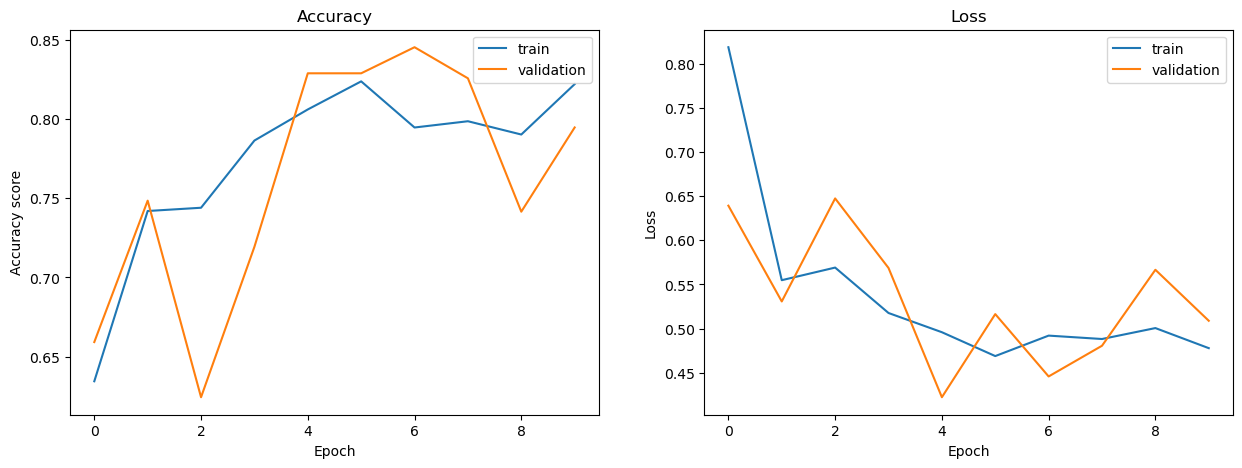

In [81]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
history = model.fit(X_trainset, epochs=25, verbose=1, validation_data=X_testset, callbacks=[earlystopping], class_weight=class_weights)
score = model.evaluate(X_testset)
plotTrainingHistory(history)

In [83]:
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step


2024-07-09 22:17:17.254436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

      Benign       0.72      0.76      0.74       510
   Malignant       0.88      0.86      0.87      1072

    accuracy                           0.83      1582
   macro avg       0.80      0.81      0.81      1582
weighted avg       0.83      0.83      0.83      1582



<Axes: >

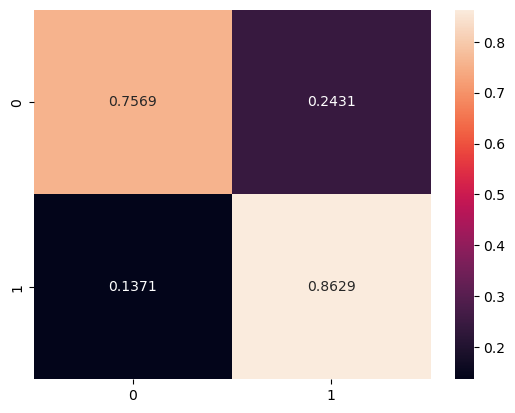

In [84]:
print(classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant"]))
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')


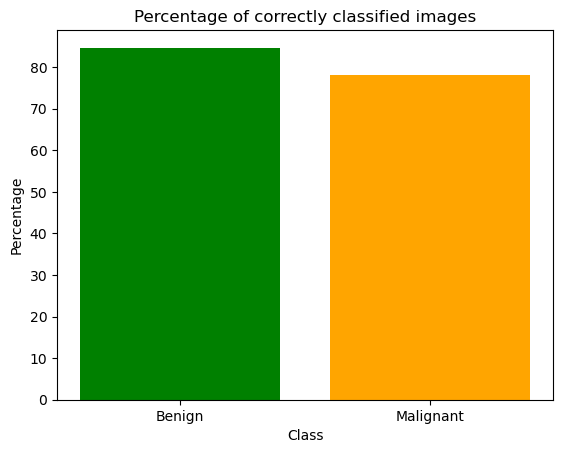

In [85]:
def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)